In [73]:
import numpy as np

t_end = 4000
input_spikes = np.zeros((t_end, 1))
input_spikes[1020:1060:20, :] = 1
input_spikes[1080:1180:30, :] = 1
input_spikes[1240, :] = 1
input_spikes[1900:2020:40, :] = 1
input_spikes[3000, :] = 1

# t_end = 600
# input_spikes = np.zeros((t_end, 1))
# input_spikes[200:340:15, :] = 1
# input_spikes[450, :] = 1

def thr_trace(thr_trace, thr, beta):
    dt = 1.
    tau_adaptation = 700
    b_decay = np.exp(-dt / tau_adaptation)
    b = 0
    for t in range(input_spikes.shape[0]):
        # new_b = self.decay_b * state.b + (np.ones(self.n_rec) - self.decay_b) * state.z
        b = b_decay * b + (1. - b_decay) * input_spikes[t]
        thr_trace[t] = thr + beta * b
    return thr_trace


alif_thr = np.zeros_like(input_spikes)
alif_thr = thr_trace(alif_thr, thr=0.01, beta=1)
elif_thr = np.zeros_like(input_spikes)
elif_thr = thr_trace(elif_thr, thr=0.02, beta=-0.5)


def w_trace(w_trace, tauD, tauF):
    U = 0.2
    dt = 1.
    u_trc = np.ones_like(input_spikes)# * U
    x_trc = np.ones_like(input_spikes)
    u = 0.
    x = 0.
    for t in range(input_spikes.shape[0]):
        z = input_spikes[t]
        # old wrong:
        # u = U + (u - U * u * z - U * (1 - z)) * np.exp(-dt / tauF)
        # x = 1. + (x - u * x * z - 1.) * np.exp(-dt / tauD)
        # Guillaume mail
        # u_t+1 = exp(-dt/tau_f) u_t + U(1 - u_t) z_t
        # x'_t+1 =  exp(-dt/tau_d) x'_t +  u_t+1 (1 - x'_t) z_t
        # x_t  = 1 - x'_t
        # Guillaume: Mongillo Tsodyks
        u = np.exp(-dt / tauF) * u + U * (1. - (u + U)) * z
        u_trc[t] = u + U
        x = np.exp(-dt / tauD) * x + u * (1. - x) * z
        x_trc[t] = 1. - x
    return u_trc * x_trc, u_trc, x_trc


def v_trace(w_trace):
    dt = 1.
    v_trc = np.zeros_like(input_spikes)
    v = 0
    for t in range(input_spikes.shape[0]): 
        z = input_spikes[t]
        v = np.exp(-dt / 20) * v + z * w_trace[t] # no reset
        v_trc[t] = v
    return v_trc


stpd_w = np.zeros_like(input_spikes)
stpd_w, stpd_u, stpd_x = w_trace(stpd_w, tauD=700, tauF=20)
stpd_v = v_trace(stpd_w)
stpf_w = np.zeros_like(input_spikes)
stpf_w, stpf_u, stpf_x = w_trace(stpf_w, tauD=200, tauF=500)
stpf_v = v_trace(stpf_w)

/home/salaj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


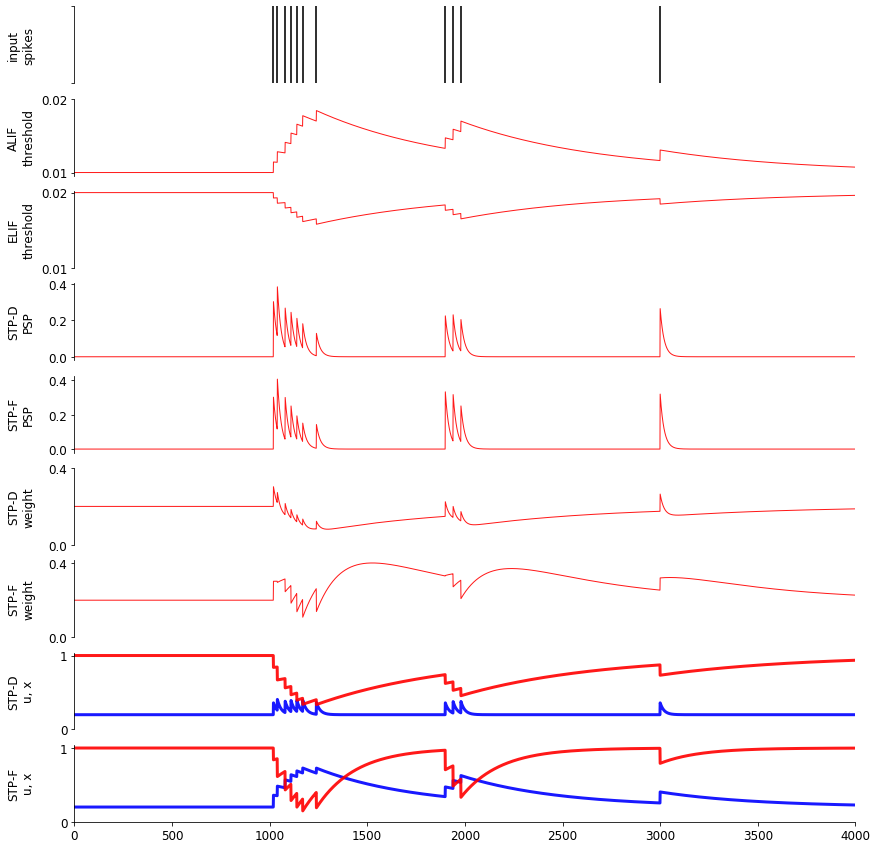

In [74]:
import matplotlib.pyplot as plt

def raster_plot(ax,spikes,linewidth=0.8,**kwargs):

    n_t,n_n = spikes.shape
    event_times,event_ids = np.where(spikes)
    max_spike = 10000
    event_times = event_times[:max_spike]
    event_ids = event_ids[:max_spike]

    for n,t in zip(event_ids,event_times):
        ax.vlines(t, n + 0., n + 1., linewidth=linewidth, **kwargs)

        
    ax.set_ylim([0 + .5, n_n + .5])
    ax.set_xlim([0, n_t])
    ax.set_yticks([0, n_n])

def strip_right_top_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

def hide_bottom_axis(ax):
    ax.spines['bottom'].set_visible(False)
    ax.set_xticklabels([])
    ax.get_xaxis().set_visible(False)

fig, ax_list = plt.subplots(nrows=9, figsize=(14, 15), gridspec_kw={'wspace': 0, 'hspace': 0.2})

ylabel_x = -0.05
ylabel_y = 0.5
la = 0.9
fs = 12
plt.rcParams.update({'font.size': fs})

# Clear the axis to print new plots
for k in range(ax_list.shape[0]):
    ax = ax_list[k]
    ax.clear()
    strip_right_top_axis(ax)

# INPUT SPIKES    
ax = ax_list[0]
raster_plot(ax, input_spikes, linewidth=1.6)
hide_bottom_axis(ax)
ax.set_ylabel("input\nspikes", fontsize=fs)
ax.get_yaxis().set_label_coords(ylabel_x, ylabel_y)
ax.set_yticks([0, 1])
ax.set_yticklabels([])
ax.set_ylim([0, 1])
ax.set_xlim([0,t_end])

# ALIF threshold trace
ax = ax_list[1]
ax.plot(alif_thr, color='r', alpha=la, linewidth=1)
hide_bottom_axis(ax)
ax.set_ylabel("ALIF\nthreshold", fontsize=fs)
ax.get_yaxis().set_label_coords(ylabel_x, ylabel_y)
ax.set_yticks([0.01, 0.02])
ax.set_xlim([0,t_end])

# ELIF threshold trace
ax = ax_list[2]
ax.plot(elif_thr, color='r', alpha=la, linewidth=1)
hide_bottom_axis(ax)
ax.set_ylabel("ELIF\nthreshold", fontsize=fs)
ax.get_yaxis().set_label_coords(ylabel_x, ylabel_y)
ax.set_yticks([0.01, 0.02])
ax.set_xlim([0,t_end])

# STP-D effective psp trace
ax = ax_list[3]
ax.plot(stpd_v, color='r', alpha=la, linewidth=1, label='weight')
# ax.plot(stpd_u, color='b', alpha=la*0.5, linewidth=1, label='u')
# ax.plot(stpd_x, color='g', alpha=la*0.5, linewidth=1, label='x')
hide_bottom_axis(ax)
ax.set_ylabel("STP-D\nPSP", fontsize=fs)
ax.get_yaxis().set_label_coords(ylabel_x, ylabel_y)
#ax.set_yticks([0, 0.4])
ax.set_xlim([0,t_end])

# STP-F effective psp trace
ax = ax_list[4]
ax.plot(stpf_v, color='r', alpha=la, linewidth=1, label='weight')
# ax.plot(stpf_u, color='b', alpha=la*0.5, linewidth=1, label='u')
# ax.plot(stpf_x, color='g', alpha=la*0.5, linewidth=1, label='x')
#ax.set_yticks([0, 0.4])
hide_bottom_axis(ax)
ax.set_ylabel("STP-F\nPSP", fontsize=fs)
ax.get_yaxis().set_label_coords(ylabel_x, ylabel_y)
ax.set_xlim([0,t_end])

# STP-D effective weight trace
ax = ax_list[5]
ax.plot(stpd_w, color='r', alpha=la, linewidth=1, label='weight')
# ax.plot(stpd_u, color='b', alpha=la*0.5, linewidth=1, label='u')
# ax.plot(stpd_x, color='g', alpha=la*0.5, linewidth=1, label='x')
hide_bottom_axis(ax)
ax.set_ylabel("STP-D\nweight", fontsize=fs)
ax.get_yaxis().set_label_coords(ylabel_x, ylabel_y)
ax.set_yticks([0, 0.4])
ax.set_xlim([0,t_end])

# STP-F effective weight trace
ax = ax_list[6]
ax.plot(stpf_w, color='r', alpha=la, linewidth=1, label='weight')
# ax.plot(stpf_u, color='b', alpha=la*0.5, linewidth=1, label='u')
# ax.plot(stpf_x, color='g', alpha=la*0.5, linewidth=1, label='x')
hide_bottom_axis(ax)
ax.set_yticks([0, 0.4])
ax.set_xlim([0,t_end])
ax.set_ylabel("STP-F\nweight", fontsize=fs)
ax.get_yaxis().set_label_coords(ylabel_x, ylabel_y)

# STP-D ux trace
ax = ax_list[7]
# ax.plot(stpd_w, color='r', alpha=la, linewidth=1, label='weight')
ax.plot(stpd_u, color='b', alpha=la, linewidth=3, label='u')
ax.plot(stpd_x, color='r', alpha=la, linewidth=3, label='x')
hide_bottom_axis(ax)
ax.set_ylabel("STP-D\nu, x", fontsize=fs)
ax.get_yaxis().set_label_coords(ylabel_x, ylabel_y)
ax.set_yticks([0, 1.])
ax.set_xlim([0,t_end])

# STP-F ux trace
ax = ax_list[8]
#ax.plot(stpf_w, color='r', alpha=la, linewidth=1, label='weight')
ax.plot(stpf_u, color='b', alpha=la, linewidth=3, label='u')
ax.plot(stpf_x, color='r', alpha=la, linewidth=3, label='x')
ax.set_yticks([0, 1.])

ax.set_ylabel("STP-F\nu, x", fontsize=fs)
ax.get_yaxis().set_label_coords(ylabel_x, ylabel_y)

#ax.set_xticks([t*1000 for t in range(5)])
#ax.set_xticklabels(['0', '', '', '', '4'])
#ax.set_xlabel("seconds", fontsize=fs)
ax.set_xlim([0,t_end])
plt.tight_layout()
plt.show()
fig.savefig('560_fig1.png', format='png')
fig.savefig('560_fig1.svg', format='svg')